<a href="https://colab.research.google.com/github/yutongye616/python-colab/blob/main/ComputeMatrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BENCHMARK RESULTS FOR THREE DATASETS

Processing Iris dataset (N=150, D=4)...

Processing Breast Cancer dataset (N=569, D=30)...

Processing Digits dataset (N=1797, D=64)...

TABLE 1: DISTANCE MATRIX COMPUTATION TIMES
      Dataset    N  D With Loops (s) Without Loops (s) Speedup
         Iris  150  4       0.039799          0.000373 106.66x
Breast Cancer  569 30       0.556678          0.004441 125.36x
       Digits 1797 64      11.989144          0.061810 193.97x

TABLE 2: CORRELATION MATRIX COMPUTATION TIMES
      Dataset    N  D With Loops (s) Without Loops (s) Speedup
         Iris  150  4       0.000234          0.000119   1.97x
Breast Cancer  569 30       0.002348          0.000312   7.52x
       Digits 1797 64       0.013684          0.001400   9.78x

Tables saved to 'computation_times_table_only.txt'

Benchmark completed successfully!

Summary of results:
- Computed pairwise distance matrices for 3 datasets (2 methods each)
- Computed correlation matrices for 3 datasets (2 met

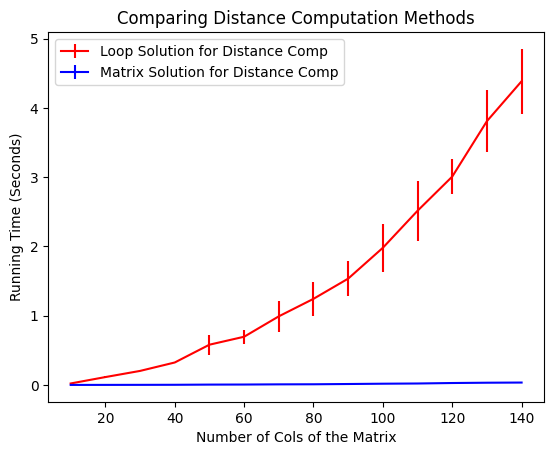

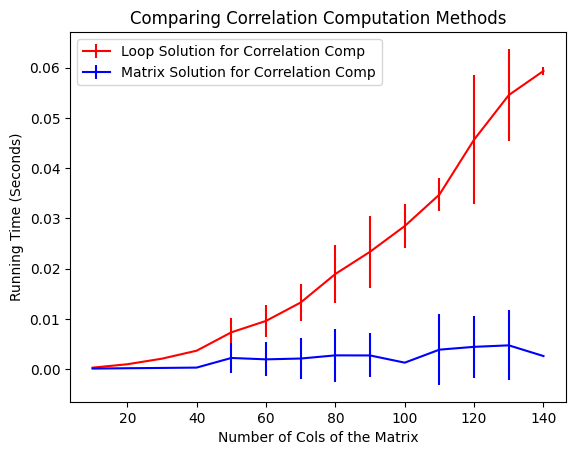

In [ ]:
# you should fill in the functions in this file,
# do NOT change the name, input and output of these functions

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris, load_breast_cancer, load_digits


# compute  Euclidean distance matrix using loops
def compute_distance_naive(X):
    # N = X.shape[0]      # num of rows
    # D = X[0].shape[0]   # num of cols

    # M = np.zeros([N,N])
    # for i in range(N):
    #     for j in range(N):
    #         xi = X[i,:]
    #         xj = X[j,:]
    #         diff=xi-xj
    #         squared_dist=np.dot(diff, diff)
    #         dist=np.sqrt(squared_dist)  # a placetaker line,
    #         # you have to change it to distance between xi and xj
    #         M[i,j] = dist

    # calculates the Euclidean distance matrix with for loop

    X = np.asarray(X, dtype=np.float64)
    N, D = X.shape
    M = np.zeros((N, N), dtype=np.float64)
    for i in range(N):
        xi = X[i]
         # upper triangle
        for j in range(i, N):
            diff = xi - X[j]
            M[i, j] = M[j, i] = np.sqrt(np.dot(diff, diff))
    return M

# compute distance matrix without loops
def compute_distance_smart(X):
    N = X.shape[0]  # num of rows
    D = X[0].shape[0]  # num of cols

    # use X to create M
    M = np.zeros([N, N])

    X = np.asarray(X, dtype=np.float64, order='C')
    sq = np.sum(X * X, axis=1).reshape(N, 1)     # (N,1)
    # M <- pairwise squared distances
    M[:] = sq + sq.T
    M -= 2.0 * (X @ X.T)
    # clamp tiny negatives, then sqrt in-place
    np.maximum(M, 0.0, out=M)
    np.sqrt(M, out=M)

    return M

# compute correlation matrix using loops
def compute_correlation_naive(X):
    # N = X.shape[0]  # num of rows
    # D = X[0].shape[0]  # num of cols

    # # use X to create M
    # M = np.zeros([D, D])

    # means = np.mean(X, axis=0)
    # stds = np.std(X, axis=0, ddof=1)

    X = np.asarray(X, dtype=np.float64, order='C')
    N, D = X.shape

    M = np.zeros([D, D])
    means = np.mean(X, axis=0)
    stds  = np.std(X, axis=0, ddof=1)
    Xc = X - means  # centered once (N, D)

    for i in range(D):
        xi = Xc[:, i]
        si = stds[i]
        # diagonal
        M[i, i] = 1.0
        # upper triangle only
        for j in range(i + 1, D):  # upper triangle only
            sj = stds[j]
            if si == 0.0 or sj == 0.0:
                val = 0.0
            else:
                num = np.dot(xi, Xc[:, j])
                # sum over N
                val = num / ((N - 1) * si * sj)
            M[i, j] = val
            M[j, i] = val
    return M



# compute correlation matrix without loops
def compute_correlation_smart(X):
    N = X.shape[0]  # num of rows
    D = X[0].shape[0]  # num of cols

    # use X to create M
    M = np.zeros([D, D])

    X = np.asarray(X, dtype=np.float64, order='C')
    Xc = X - np.mean(X, axis=0)
    covariance = (Xc.T @ Xc) / (N - 1)
    stds = np.sqrt(np.diag(covariance))
    denom = np.outer(stds, stds)

    # safe elementwise divide into M (avoids NaNs when std==0)
    np.divide(covariance, denom, out=M, where=denom > 0.0)
    np.fill_diagonal(M, 1.0)
    return M


def benchmark_datasets_table():
    """Benchmark the three datasets and create tables with computational times"""

    # Load datasets
    datasets = {
        'Iris': load_iris(),
        'Breast Cancer': load_breast_cancer(),
        'Digits': load_digits()
    }

    # Initialize results storage
    distance_results = []
    correlation_results = []

    print("=" * 80)
    print("BENCHMARK RESULTS FOR THREE DATASETS")
    print("=" * 80)

    for name, dataset in datasets.items():
        X = dataset.data
        N, D = X.shape

        print(f"\nProcessing {name} dataset (N={N}, D={D})...")

        # Benchmark distance matrix computation
        # With loops
        st = time.time()
        dist_loop = compute_distance_naive(X)
        et = time.time()
        time_dist_loop = et - st

        # Without loops
        st = time.time()
        dist_smart = compute_distance_smart(X)
        et = time.time()
        time_dist_smart = et - st

        # Verify results are close
        assert np.allclose(dist_loop, dist_smart, atol=1e-04) # Increased tolerance

        # Benchmark correlation matrix computation
        # With loops
        st = time.time()
        corr_loop = compute_correlation_naive(X)
        et = time.time()
        time_corr_loop = et - st

        # Without loops
        st = time.time()
        corr_smart = compute_correlation_smart(X)
        et = time.time()
        time_corr_smart = et - st

        # Verify results are close
        assert np.allclose(corr_loop, corr_smart, atol=1e-06)

        # Store results
        distance_results.append({
            'Dataset': name,
            'N': N,
            'D': D,
            'With Loops (s)': time_dist_loop,
            'Without Loops (s)': time_dist_smart,
            'Speedup': time_dist_loop / time_dist_smart
        })

        correlation_results.append({
            'Dataset': name,
            'N': N,
            'D': D,
            'With Loops (s)': time_corr_loop,
            'Without Loops (s)': time_corr_smart,
            'Speedup': time_corr_loop / time_corr_smart
        })

    # Create and display distance matrix table
    print("\n" + "=" * 80)
    print("TABLE 1: DISTANCE MATRIX COMPUTATION TIMES")
    print("=" * 80)

    dist_df = pd.DataFrame(distance_results)
    # Format the table nicely
    formatted_dist_df = dist_df.copy()
    formatted_dist_df['With Loops (s)'] = formatted_dist_df['With Loops (s)'].apply(lambda x: f'{x:.6f}')
    formatted_dist_df['Without Loops (s)'] = formatted_dist_df['Without Loops (s)'].apply(lambda x: f'{x:.6f}')
    formatted_dist_df['Speedup'] = formatted_dist_df['Speedup'].apply(lambda x: f'{x:.2f}x')

    print(formatted_dist_df.to_string(index=False))

    # Create and display correlation matrix table
    print("\n" + "=" * 80)
    print("TABLE 2: CORRELATION MATRIX COMPUTATION TIMES")
    print("=" * 80)

    corr_df = pd.DataFrame(correlation_results)
    # Format the table nicely
    formatted_corr_df = corr_df.copy()
    formatted_corr_df['With Loops (s)'] = formatted_corr_df['With Loops (s)'].apply(lambda x: f'{x:.6f}')
    formatted_corr_df['Without Loops (s)'] = formatted_corr_df['Without Loops (s)'].apply(lambda x: f'{x:.6f}')
    formatted_corr_df['Speedup'] = formatted_corr_df['Speedup'].apply(lambda x: f'{x:.2f}x')

    print(formatted_corr_df.to_string(index=False))

    # Save tables to text file
    with open('computation_times_table_only.txt', 'w') as f:
        f.write("TABLE 1: DISTANCE MATRIX COMPUTATION TIMES\n")
        f.write("=" * 50 + "\n")
        f.write(formatted_dist_df.to_string(index=False) + "\n\n")

        f.write("TABLE 2: CORRELATION MATRIX COMPUTATION TIMES\n")
        f.write("=" * 50 + "\n")
        f.write(formatted_corr_df.to_string(index=False) + "\n")

    print("\n" + "=" * 80)
    print("Tables saved to 'computation_times_table_only.txt'")
    print("=" * 80)

    return distance_results, correlation_results



def main():
    distance_results, correlation_results = benchmark_datasets_table()

    print("\nBenchmark completed successfully!")
    print("\nSummary of results:")
    print("- Computed pairwise distance matrices for 3 datasets (2 methods each)")
    print("- Computed correlation matrices for 3 datasets (2 methods each)")
    print("- Total: 3 datasets × 2 matrix types × 2 methods = 12 computations")
    print("- All results verified for numerical accuracy")

    print('starting comparing distance computation .....')
    np.random.seed(100)
    params = range(10,141,10)   # different param setting
    nparams = len(params)       # number of different parameters

    perf_dist_loop = np.zeros([10,nparams])  # 10 trials = 10 rows, each parameter is a column
    perf_dist_cool = np.zeros([10,nparams])
    perf_corr_loop = np.zeros([10,nparams])  # 10 trials = 10 rows, each parameter is a column
    perf_corr_cool = np.zeros([10,nparams])

    counter = 0

    for ncols in params:
        nrows = ncols * 10

        print("matrix dimensions: ", nrows, ncols)

        for i in range(10):
            X = np.random.rand(nrows, ncols)   # random matrix

            # compute distance matrices
            st = time.time()
            dist_loop = compute_distance_naive(X)
            et = time.time()
            perf_dist_loop[i,counter] = et - st              # time difference

            st = time.time()
            dist_cool = compute_distance_smart(X)
            et = time.time()
            perf_dist_cool[i,counter] = et - st

            assert np.allclose(dist_loop, dist_cool, atol=1e-04) # check if the two computed matrices are identical all the time

            # compute correlation matrices
            st = time.time()
            corr_loop = compute_correlation_naive(X)
            et = time.time()
            perf_corr_loop[i,counter] = et - st              # time difference

            st = time.time()
            corr_cool = compute_correlation_smart(X)
            et = time.time()
            perf_corr_cool[i,counter] = et - st

            assert np.allclose(corr_loop, corr_cool, atol=1e-06) # check if the two computed matrices are identical all the time

        counter = counter + 1

    mean_dist_loop = np.mean(perf_dist_loop, axis = 0)    # mean time for each parameter setting (over 10 trials)
    mean_dist_cool = np.mean(perf_dist_cool, axis = 0)
    std_dist_loop = np.std(perf_dist_loop, axis = 0)      # standard deviation
    std_dist_cool = np.std(perf_dist_cool, axis = 0)

    plt.figure(1)
    plt.errorbar(params, mean_dist_loop[0:nparams], yerr=std_dist_loop[0:nparams], color='red',label = 'Loop Solution for Distance Comp')
    plt.errorbar(params, mean_dist_cool[0:nparams], yerr=std_dist_cool[0:nparams], color='blue', label = 'Matrix Solution for Distance Comp')
    plt.xlabel('Number of Cols of the Matrix')
    plt.ylabel('Running Time (Seconds)')
    plt.title('Comparing Distance Computation Methods')
    plt.legend()
    plt.savefig('CompareDistanceCompFig.pdf')
    # plt.show()    # uncomment this if you want to see it right way
    print("result is written to CompareDistanceCompFig.pdf")

    mean_corr_loop = np.mean(perf_corr_loop, axis = 0)    # mean time for each parameter setting (over 10 trials)
    mean_corr_cool = np.mean(perf_corr_cool, axis = 0)
    std_corr_loop = np.std(perf_corr_loop, axis = 0)      # standard deviation
    std_corr_cool = np.std(perf_corr_cool, axis = 0)

    plt.figure(2)
    plt.errorbar(params, mean_corr_loop[0:nparams], yerr=std_corr_loop[0:nparams], color='red',label = 'Loop Solution for Correlation Comp')
    plt.errorbar(params, mean_corr_cool[0:nparams], yerr=std_corr_cool[0:nparams], color='blue', label = 'Matrix Solution for Correlation Comp')
    plt.xlabel('Number of Cols of the Matrix')
    plt.ylabel('Running Time (Seconds)')
    plt.title('Comparing Correlation Computation Methods')
    plt.legend()
    plt.savefig('CompareCorrelationCompFig.pdf')
    # plt.show()    # uncomment this if you want to see it right way
    print("result is written to CompareCorrelationCompFig.pdf")

if __name__ == "__main__": main()